Autoencoder Anomaly Testing
===

This is rebuilt from the "Collecting Network Statistics" notebook. The goal of this notebook is to collect together a set of in-distribution and out-of-distribution images and confirm that the model can distinguish them with a high degree of accuracy.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import math

from pytorch_msssim import ssim,ms_ssim,SSIM
from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder
from CustomDataSet import CustomDataSet,CustomDataSetWithError
from GaussianNoise import AddGaussianNoiseAndRescale
import os

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
#seed = 2662
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

basis = "holdout"
distribution = "screening"

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
#platform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 1

#meta-parameters
l2_decay = 0.0
dropout_rate = 0.1
code_sides = [20]
convolution_filters = 32

model_extension = str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay)
full_extension = "_" + basis + "_" + distribution + "_" + model_extension

model_path = "../../Data/OPTIMAM_NEW/model" + full_extension + ".pt"

#image_count = 500
image_count = -1

validation_split = 0.95

## Gather Base Distribution Information

First we run the model on the entire original distribution and gather statistics on the loss values, encodings etc.

In [4]:
from torchvision.transforms import ToTensor,Normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

if distribution=="screening":
    root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/" + str(width)
else:
    root_dir = "../../Data/OPTIMAM_NEW/png_images/lesions"
train_dataset = CustomDataSet(root_dir, transform)

if (image_count == -1):
    train_dataset_subset = train_dataset
    image_count = len(train_dataset)
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

train_subset_idx = np.random.choice(len(train_dataset), int(image_count * validation_split), replace=False)

n = np.arange(len(train_dataset))
mask = np.ones(len(train_dataset), dtype=bool)
mask[train_subset_idx] = False
holdout_subset_idx = n[mask]

dataset_size = len(train_dataset_subset)
      
t_subset = torch.utils.data.Subset(train_dataset_subset, train_subset_idx)

train_loader = torch.utils.data.DataLoader(
    t_subset, batch_size=batch_size, shuffle=False
)

h_subset = torch.utils.data.Subset(train_dataset_subset, holdout_subset_idx)

holdout_loader = torch.utils.data.DataLoader(
    h_subset, batch_size=batch_size, shuffle=False
)

In [5]:
print(train_subset_idx)
print(holdout_subset_idx)

[ 337 2830 2718 ... 1455 1771  301]
[  28   38   42   92  137  141  168  184  196  236  244  248  290  292
  338  343  354  359  362  427  435  454  465  478  496  535  543  554
  582  587  611  615  624  627  666  669  675  684  726  731  752  767
  776  802  828  835  865  885  889  918  927 1034 1038 1042 1044 1045
 1105 1146 1149 1151 1188 1208 1231 1242 1264 1269 1270 1277 1290 1301
 1309 1317 1338 1365 1399 1413 1430 1480 1528 1537 1538 1552 1581 1598
 1620 1628 1637 1640 1662 1709 1806 1865 1879 1916 1927 1949 1957 1971
 1983 2069 2074 2120 2123 2164 2172 2180 2186 2210 2232 2261 2307 2311
 2331 2333 2358 2374 2378 2395 2399 2433 2439 2478 2491 2548 2553 2608
 2669 2680 2716 2719 2725 2741 2765 2789 2810 2831 2844 2862 2924 2944
 2979 2986 3003 3007 3034 3041 3063 3065 3067 3075 3090 3091 3096 3108
 3120 3133 3134 3176 3183 3195 3208 3217 3279 3291 3322 3336 3363 3376
 3391 3395 3402 3409 3441 3453 3511 3521 3545 3549 3561 3591 3599 3624
 3639 3670]


In [6]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

code_size = code_sides[0] * code_sides[0]

# mean-squared error loss
criterion = nn.MSELoss()

features = [None] * len(t_subset)
losses = [None] * len(t_subset)
encodings = [None] * len(t_subset)
outputs = [None] * len(t_subset)

In [7]:
# reload the saved model
model = torch.load(model_path,map_location=device)
model.eval()

SplitAutoencoder(
  (encoder): ExtensibleEncoder(
    (cnnStage): Sequential(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout2d(p=0.0, inplace=True)
      (relu1): ReLU()
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout2): Dropout2d(p=0.0, inplace=True)
      (relu2): ReLU()
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout3): Dropout2d(p=0.0, inplace=True)
      (relu3): ReLU()
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (fc1): Linear(in_features=131072, out_features=400, bias=True)
  )
  (decoder): ExtensibleDecoder(
    (cnnStage): Sequential(


We run our autoencoder on the entire dataset and store the encodings

In [8]:
with torch.no_grad():
    count = 0
    for batch_features in train_loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        features[count] = batch_features.cpu()
        
        # compute reconstructions
        code = model.encoder(batch_features)
        output = model.decoder(code)
        
        outputs[count] = output.cpu()
        
        code_reshaped = code.detach().cpu().numpy()[0]
        code_reshaped.reshape(code_size)

        encodings[count] = code_reshaped

        # compute training reconstruction loss
        error_criterion = criterion(output,batch_features)

        losses[count] = error_criterion.cpu().numpy()

        count = count + 1

C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


And calculate the encoding statistics:

In [9]:
print(len(encodings))
print(len(encodings[0]))
print(len(losses))

3493
400
3493


In [10]:
mse_min = np.amin(losses)
mse_max = np.amax(losses)
mse_mean = np.mean(losses)
mse_std = np.std(losses)
print("MSE Min/Mean/Max/SD:" + str(mse_min) + "/" + str(mse_mean) + "/" + str(mse_max) + "/" + str(mse_std)   )

MSE Min/Mean/Max/SD:0.0003135106/0.001959405/0.03445597/0.0013833629


In [11]:
features_n = np.stack(features)
outputs_n = np.stack(outputs)
print(features_n.shape)
print(outputs_n.shape)

pre_ssims = [None] * len(encodings)

ssim_module = SSIM(data_range=1.0, size_average=False, channel=3)

for i in range(len(encodings)):
    features_s = features_n[i].reshape(1,1,height,width).repeat(3,1)
    outputs_s = outputs_n[i].reshape(1,1,height,width).repeat(3,1)
    ssim_f = ssim_module(torch.from_numpy(features_s), torch.from_numpy(outputs_s))
    pre_ssims[i] = ssim_f.item()
    
ssim_min = np.amin(pre_ssims)
ssim_max = np.amax(pre_ssims)
ssim_mean = np.mean(pre_ssims)
ssim_sd = np.std(pre_ssims)
print("SSIM Min/Mean/Max/SD:" + str(ssim_min) + "/" + str(ssim_mean) + "/" + str(ssim_max) + "/" + str(ssim_sd))

(3493, 1, 1, 256, 256)
(3493, 1, 1, 256, 256)
SSIM Min/Mean/Max/SD:0.42311474680900574/0.8151447367453145/0.9703370928764343/0.07189667546710785


Now we save the compiled statistics to an excel file.

In [12]:
with torch.no_grad():
    np_losses = np.asarray(losses)
    np_pre_ssims = np.asarray(pre_ssims)
    np_compiled = np.concatenate((np_losses[:, np.newaxis], encodings), axis=1)

    suffix = full_extension
    
    np.savetxt('base_encodings' + suffix + '.csv', encodings, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_losses' + suffix + '.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_ssim' + suffix + '.csv', np_pre_ssims, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_combined' + suffix + '.csv', np_compiled, delimiter=',',fmt='%10.5f',newline='\n')

## Adversarials

We have 2 Datasets (mammographic and non-mammographic) and 3 DataLoaders - Clean Mammo, Distorted Mammo, and Non-Mammo. The goal here is to build an analogously large set of OOD images and test to what degree the autoencoder is capable of detecting the distortions.

The first method for doing this builds a large set of all the datasets classified into In-Distribution and Out-Of-Distribution and determine the accuracy rating of the model as a classifier. The second generates a set of distorted mammographic images at specified distances from the distribution, along with a value roughly analogous to that distortion level. This second method is intended to determine the range in distribution space at which the model becomes able to distinguish, as well as the degree of "grey area" between in and out of distribution (as detected).

In [13]:
with torch.no_grad():
    trigger_chance = 0.4

    PIL_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=10,translate=(0.2,0.2),shear=25),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
#        torchvision.transforms.GaussianBlur(kernel_size=3)
        ],p=trigger_chance)
    
    tensor_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomErasing(p=1.0,value='random'),
        torchvision.transforms.Lambda(lambda x : x + (torch.randn_like(x) * 0.2))
#        AddGaussianNoiseAndRescale(0.0,0.2)
        ],p=trigger_chance)

    adversarial_transform = torchvision.transforms.Compose([        
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.0,65535.0),
        PIL_transforms,
        tensor_transforms,
        AddGaussianNoiseAndRescale(0.0,0.00)
        ])
   
    adversarial_image_count = image_count
    adversarial_dataset = CustomDataSetWithError(root_dir, adversarial_transform)
    
    if(basis == "holdout"): 
        a_subset = torch.utils.data.Subset(adversarial_dataset, holdout_subset_idx)
    else:
        a_subset = torch.utils.data.Subset(adversarial_dataset, train_subset_idx)

    adversarial_loader = torch.utils.data.DataLoader(
        a_subset,shuffle=True
    )
    
    

Build the first (mixed) set:

In [14]:
with torch.no_grad():
    adversarial_iterator = iter(adversarial_loader)
    genuine_iterator = iter(holdout_loader)
    mixed_set_scale = 300
    
    mixed_set = []
    mixed_set_np = []
    mixed_class_set = []
    mixed_error_set = []
    for i in range(mixed_set_scale):
        r = torch.rand(1)
        if(r.item() > 0.5):
            error = 0.0
            while(error==0.0):
                try:
                    adversarial_t = next(adversarial_iterator)
                    adversarial = adversarial_t[0].cpu()
                    adversarial_np = adversarial.numpy().reshape(width,height)
                    error = adversarial_t[1].item()
                except StopIteration:
                    adversarial_iterator = iter(adversarial_loader)
            mixed_class_set.append(0)
            mixed_set_np.append(adversarial_np)
            mixed_set.append(adversarial)
            mixed_error_set.append(error)
            print("Positive: Min " + str(np.amin(adversarial_np)) + " Max " + str(np.amax(adversarial_np)) + " Error " + str(error))
        else:
            genuine = next(genuine_iterator).cpu()
            genuine_np = genuine.numpy().reshape(width,height)
            mixed_class_set.append(1)
            mixed_set.append(genuine)
            mixed_set_np.append(genuine_np)
            mixed_error_set.append(0.0) # genuine, so no drift
            print("Negative: Min " + str(np.amin(genuine_np)) + " Max " + str(np.amax(genuine_np)) + " Error 0.0")
        
    mixed_code_set = []
    mixed_reconstruction_set = []
    mixed_losses = []

Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.24333709478378296
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.20958620309829712
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.11199228465557098
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.16231891512870789
Positive: Min 0.0 Max 1.0 Error 0.19272682070732117
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.21851664781570435
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.04744119197130203
Positive: Min 0.0 Max 1.0 Error 0.027081571519374847
Positive: Min 0.0 Max 1.0 Error 0.18019171059131622
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.016139060258865356
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: 

C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.1639048010110855
Positive: Min 0.0 Max 1.0 Error 0.1026243194937706
Positive: Min 0.0 Max 1.0 Error 0.0345645546913147
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.18244580924510956
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.05550850182771683
Positive: Min 0.0 Max 1.0 Error 0.2058795839548111
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.04455847293138504
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.03516262397170067
Positive: Min 0.0 Max 1.0 Error 0.028282690793275833
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.09565688669681549
Negative: Min 0

Now run the model on the mixed set:

In [15]:
with torch.no_grad():
    count = 0
    for mixed_item in mixed_set:
        mixed_example = mixed_item.to(device)
        
        n_code = model.encoder(mixed_example)
        reconstruction = model(mixed_example)
        
        mixed_code_set.append(n_code.cpu())
        mixed_reconstruction_set.append(reconstruction.cpu())
        
        error_criterion = criterion(reconstruction,mixed_example)
        loss = error_criterion.cpu().numpy()
        print(loss)
        mixed_losses.append(loss)

0.001181301
0.097958624
0.0007812409
0.0020200864
0.0601336
0.0013078705
0.006166847
0.0013885993
0.064552516
0.070842914
0.0012192789
0.0012131054
0.09286867
0.0025226907
0.0019916508
0.012229374
0.014637802
0.07966026
0.008116068
0.0015748488
0.0077457647
0.0012507138
0.0013750646
0.0017842442
0.001795397
0.0013601462
0.0024759716
0.0008817563
0.08350539
0.001274329
0.0012120713
0.0046046656
0.0014771778
0.0014642761
0.071988955
0.025829323
0.001461143
0.07525306
0.022273999
0.002799556
0.106776655
0.0024510208
0.0048147063
0.019270554
0.0031803166
0.0012176179
0.010246923
0.0011570705
0.041907795
0.0022475212
0.053846188
0.0029156352
0.0038386746
0.06713632
0.0093508065
0.01316268
0.0012317598
0.0013471075
0.06399371
0.0020436614
0.00086029724
0.016936375
0.072870865
0.0009463014
0.008688908
0.00157598
0.016492056
0.011494265
0.0008933778
0.00229178
0.0016814659
0.001280034
0.002285942
0.019376036
0.0037798123
0.0014780656
0.002318583
0.065605864
0.0009312129
0.01488802
0.06282136
0

Next, measure the loss and feature statistics for the adversarials:            

#### Mean Squared Error (MSE):

First calculate the MSE for all the reconstructed images.

In [16]:
mixed_losses_np = np.asarray(mixed_losses)
post_mse_min = np.amin(mixed_losses_np)
post_mse_max = np.amax(mixed_losses_np)
post_mse_mean = np.mean(mixed_losses_np)
post_mse_std = np.std(mixed_losses_np)
print("Prediction MSE Min/Mean/Max/SD:" + str(post_mse_min) + "/" + str(post_mse_mean) + "/" + str(post_mse_max) + "/" + str(post_mse_std))

Prediction MSE Min/Mean/Max/SD:0.00032529558/0.026316384/0.112509176/0.034706704


And attempt to predict classes based on MSE:

In [17]:
mse_threshold = mse_mean + (2 * mse_std)

predicted_class = []
for i in range(mixed_set_scale):
    if(mixed_losses_np[i]<mse_threshold):
        predicted_class.append(1) # distribution
    else:
        predicted_class.append(0) # adversarial

mixed_class_np = np.asarray(mixed_class_set)
predicted_class_np = np.asarray(predicted_class)
print(mixed_class_np)
print(predicted_class_np)
matches = (mixed_class_np == predicted_class_np)
print(matches)
hits = np.count_nonzero(matches)
misses = mixed_set_scale - hits
accuracy = hits / mixed_set_scale
print("Accuracy:" + str(accuracy))

fails = np.where(matches==False)
print(fails)

[1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1
 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 1 0 0 1]
[1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0
 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1
 0 1 0 1 1 1 0 

#### STRUCTURAL SIMILARITY INDEX (SSIM)

Generate RGB versions of the base and recreated images.

In [18]:
mixed_set_s = np.stack(mixed_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
mixed_recon_s = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
print(mixed_set_s.shape)
print(mixed_recon_s.shape)

(300, 3, 256, 256)
(300, 3, 256, 256)


And use that for Structural Similarity Index:

In [19]:
ssim_t = ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)
ms_ssim_t = ms_ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)

In [20]:
post_ssim_min = np.amin(ssim_t.numpy())
post_ssim_max = np.amax(ssim_t.numpy())
post_ssim_mean = np.mean(ssim_t.numpy())
post_ssim_std = np.std(ssim_t.numpy())
print("Prediction SSIM Min/Mean/Max/SD:" + str(post_ssim_min) + "/" + str(post_ssim_mean) + "/" + str(post_ssim_max) + "/" + str(post_ssim_std))

Prediction SSIM Min/Mean/Max/SD:0.13633026/0.6052679/0.9524661/0.27209574


In [21]:
with torch.no_grad():
    np_post_losses = np.asarray(mixed_losses_np)
    np_post_ssims = np.asarray(ssim_t)
    np_distances = np.asarray(mixed_error_set)
    
    suffix = full_extension
    
    np.savetxt('mixed_losses' + suffix + '.csv', np_post_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('mixed_ssim' + suffix + '.csv', np_post_ssims, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('mixed_distance' + suffix + '.csv', np_distances, delimiter=',',fmt='%10.5f',newline='\n')

Attempt to predict the class based on the SSIM:

In [22]:
ssim_threshold = ssim_mean - (2 * ssim_sd)
#ssim_threshold = ssim_min
predicted_class = []
for i in range(mixed_set_scale):
    if(ssim_t[i]>ssim_threshold):
        predicted_class.append(1) # distribution
    else:
        predicted_class.append(0) # adversarial

mixed_class_np = np.asarray(mixed_class_set)
predicted_class_np = np.asarray(predicted_class)
print(mixed_class_np)
print(predicted_class_np)
matches = (mixed_class_np == predicted_class_np)
print(matches)
hits = np.count_nonzero(matches)
misses = mixed_set_scale - hits
accuracy = hits / mixed_set_scale
print("Accuracy:" + str(accuracy))

[1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1
 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 1 0 0 1]
[1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0
 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0
 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1
 1 1 0 1 1 1 0 

And plot the first 10 results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 256, 256, 3)
(300, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


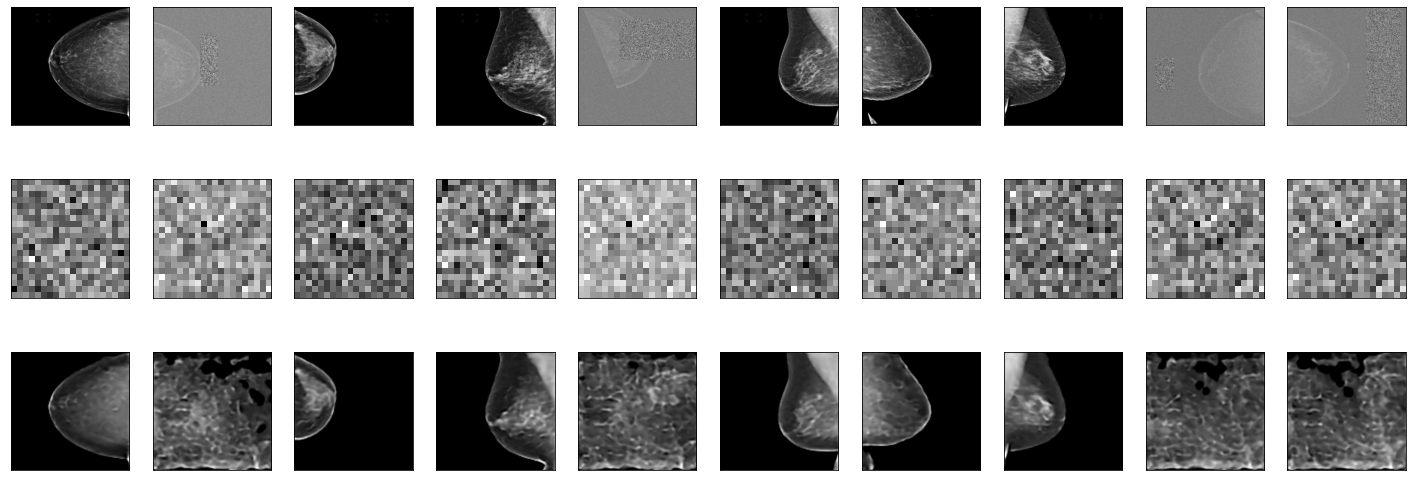

In [23]:
with torch.no_grad():
    mixed_set_g = np.stack(mixed_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    mixed_recon_g = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    print(mixed_set_g.shape)
    print(mixed_recon_g.shape)

    #number = mixed_set_scale
    number = 10
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = mixed_set_g
        copyback = test_examples[index]
        print(copyback.shape)
        plt.imshow(copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + number + 1)
        codes = mixed_code_set
        code_copyback = codes[index].cpu()
        plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + (number*2) + 1)
        reconstruction = mixed_recon_g
        recon_copyback = reconstruction[index]
        plt.imshow(recon_copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    out_path = "adv_output" + full_extension + ".png"
    plt.savefig(out_path)
    plt.show()

And plot the failures from the MSE calculation:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


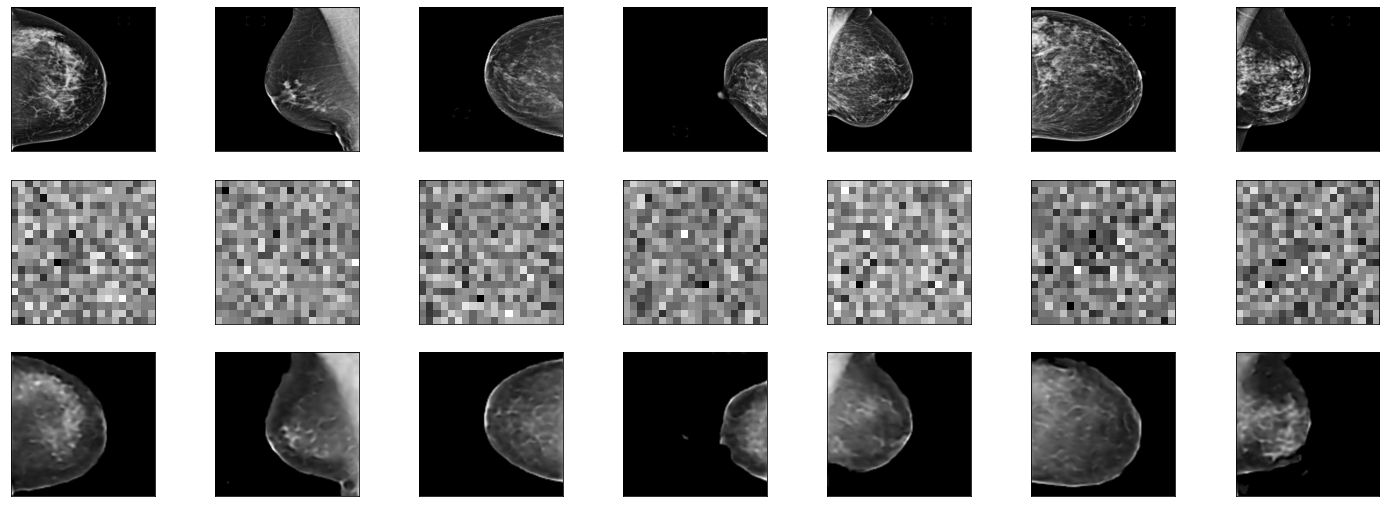

In [24]:
with torch.no_grad():
    if(len(fails[0])<10):
        #number = mixed_set_scale
        number = len(fails[0])
        plt.figure(figsize=(25, 9))
        for index in range(number):
            image_index = fails[0][index]
            # display original
            ax = plt.subplot(3, number, index + 1)
            test_examples = mixed_set_g
            copyback = test_examples[image_index]
            print(copyback.shape)
            plt.imshow(copyback)
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display codes
            ax = plt.subplot(3, number, index + number + 1)
            codes = mixed_code_set
            code_copyback = codes[image_index].cpu()
            plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(3, number, index + (number*2) + 1)
            reconstruction = mixed_recon_g
            recon_copyback = reconstruction[image_index]
            plt.imshow(recon_copyback)
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        out_path = "fail_output" + full_extension + ".png"
        plt.savefig(out_path)
        plt.show()

Finally, plot projected error against reconstructed MSE:

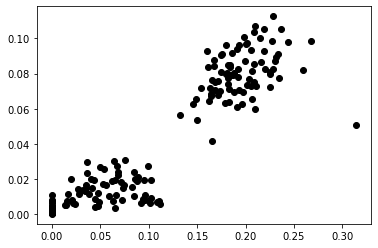

In [25]:
plt.plot(mixed_error_set, np_post_losses, 'o', color='black');
out_path = "graph_output" + full_extension + ".png"
plt.savefig(out_path)